In [8]:
import io
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts

seaborn.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

NameError: name 'seaborn' is not defined

In [9]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

**División en dos dataframes por Género**

-----

Vamos a incorporar los criterios hechos en la parte 1 del entregable.

In [10]:
# Criterios empleados para la parte 1 del entregable:

##Tipo de trabajo :
df_P2 = df[df['work_contract_type']!='Part-Time']
criterios = [df_P2['work_contract_type']=='Tercerizado (trabajo a través de consultora o agencia)',df_P2['work_contract_type']=='Remoto (empresa de otro país)']
etiquetas = ['Tercerizado','Remoto']
df_P2['work_contract_type'] = np.select(criterios, etiquetas, default=df_P2['work_contract_type'])

##Provincia 
provincias = ['Ciudad Autónoma de Buenos Aires','GBA','Provincia de Buenos Aires','Córdoba','Santa Fe']
df_P2 = df_P2[df_P2['work_province'].isin(provincias)]
criterios = [df_P2['work_province']=='Ciudad Autónoma de Buenos Aires', df_P2['work_province']=='Provincia de Buenos Aires']
etiquetas = ['CABA','Prov. Bs As']
df_P2['work_province'] = np.select(criterios, etiquetas, default=df_P2['work_province'])

##Sueldo neto
sueldo_minimo = 16875
q_max = df['salary_monthly_NETO'].quantile(0.98)
df_P2 = df_P2[(df_P2['salary_monthly_NETO'] > sueldo_minimo) & (df_P2['salary_monthly_NETO'] < q_max)]

##Filtros de sueldo neto y bruto
sueldo_minimo = 16875 #sueldo minimo vital y móvil en Agosto 2020
q_max_neto = df['salary_monthly_NETO'].quantile(0.95)
q_max_bruto = df['salary_monthly_BRUTO'].quantile(0.95)

df_P2 = df[(df['salary_monthly_NETO'] > sueldo_minimo) & (df['salary_monthly_NETO'] < q_max_neto)]
df_P2 = df_P2[(df_P2['salary_monthly_BRUTO'] > sueldo_minimo) & (df_P2['salary_monthly_BRUTO'] < q_max_bruto)]

##Provincia 
provincias = ['Ciudad Autónoma de Buenos Aires','GBA','Provincia de Buenos Aires','Córdoba','Santa Fe']
df_P2 = df_P2[df_P2['work_province'].isin(provincias)]

##Filtramos errores en experiencia
df_P2 = df_P2[df_P2['profile_years_experience']<df_P2['profile_age']]

##Variable categórica de experiencia
criterios = [df_P2['profile_years_experience']<2, (df_P2['profile_years_experience']>= 2) & (df_P2['profile_years_experience']< 5), df_P2['profile_years_experience']>=5]
etiquetas = ['Junior','Semi-Senior','Senior']

df_P2['experiencia'] = np.select(criterios, etiquetas)

<ipython-input-10-82b4ca1c4c4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2['work_contract_type'] = np.select(criterios, etiquetas, default=df_P2['work_contract_type'])


Aplicados los filtros de la parte 1, todos los trabajadores del Dataset resultante ganan al menos 17000 pesos. 

In [11]:
min(df_P2.salary_monthly_NETO)

17000.0

Se le hace un **describe()** a la columna de salario NETO, distinguiendo por género.

In [12]:
df_P2[df_P2.salary_monthly_NETO > sueldo_minimo]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                       \
                             count          mean           std      min   
profile_gender                                                            
Hombre                      4017.0  84166.255163  37268.872431  17000.0   
Mujer                        790.0  73900.459557  33609.228656  20000.0   
Otros                         23.0  83108.695652  45396.144340  34000.0   

                                                       
                     25%      50%       75%       max  
profile_gender                                         
Hombre          55550.75  80000.0  105000.0  209480.0  
Mujer           49125.00  67846.0   92375.0  203000.0  
Otros           40000.00  76800.0  108000.0  190000.0

Comparamos con el filtro que venía en el enunciado:

In [13]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4815.0  101481.624343  102215.304684   1100.0   
Mujer                        863.0   77328.913778   55082.760570   2000.0   
Otros                         28.0  105660.714286   87235.710235  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          55000.0  80000.0  110000.0  2080000.0  
Mujer           47850.0  67200.0   93000.0   800000.0  
Otros           43750.0  78900.0  122750.0   380000.0

Aplicando sólo el filtrado por mìnimo 1000 de sueldo neto teníamos en total

1.   4815 hombres
2.   863 mujeres y 28 de otro género.

Ahora con el filtrado por el sueldo mínimo y excluyendo el quantil 2% tenemos y considerando sólo las provincias más representativas, tenemos:

1.   4017 hombres
2.   790 mujeres y 23 de otro género.

Vamos a continuar con el DataFrame **df_P2**, para el que no es necesario aplicar el filtro de salario mayor a 1000 pesos.

In [14]:
is_man = df_P2.profile_gender == 'Hombre'
#--------------------------------------------------------------------------------
# División por género considerando con los criterios del entregable 1

groupA = df_P2[is_man].salary_monthly_NETO
groupB = df_P2[~is_man].salary_monthly_NETO
#-------------------------------------------------------------------------------

In [15]:
nb = groupB.count()
groupB.describe()

count       813.000000
mean      74160.963161
std       33996.371716
min       20000.000000
25%       49000.000000
50%       68000.000000
75%       92500.000000
max      203000.000000
Name: salary_monthly_NETO, dtype: float64

In [16]:
na = groupA.count()
groupA.describe()

count      4017.000000
mean      84166.255163
std       37268.872431
min       17000.000000
25%       55550.750000
50%       80000.000000
75%      105000.000000
max      209480.000000
Name: salary_monthly_NETO, dtype: float64

In [17]:
alpha = 0.05

## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

In [18]:
medianA = groupA.median()
medianB = groupB.median()

In [19]:
meanA = groupA.mean()
meanB = groupB.mean()
print("OPC. 1 MEDIA HOMBRES (media aritmética):\t", meanB)

# Hay muchas medias en la biblioteca de scipy. CAda una se calcula de distinta forma
hmeanB = sts.gmean(groupB)
print("OPC. 2 MEDIA HOMBRES (media geométrica):\t",hmeanB)
print("OPC. 3 MEDIA HOMBRES (media armónica):\t\t",sts.hmean(groupB))

OPC. 1 MEDIA HOMBRES (media aritmética):	 74160.96316113161
OPC. 2 MEDIA HOMBRES (media geométrica):	 67143.8167084617
OPC. 3 MEDIA HOMBRES (media armónica):		 60776.96595722053


In [20]:
q_025_A = groupA.quantile(0.025)
q_975_A = groupA.quantile(0.975)
stdA = groupA.std()
print('Desviacion estandar grupo A \t'+str(stdA))

q_025_B = groupB.quantile(0.025)
q_975_B = groupB.quantile(0.975)
stdB = groupB.std()
print('Desviacion estandar grupo B \t'+str(stdB))

Desviacion estandar grupo A 	37268.87243138481
Desviacion estandar grupo B 	33996.37171598557


<ipython-input-22-c26f92257561>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=str(q_025_A-(meanA-2*stdA)), xy=(meanA-2*stdA, 220), fontsize=10)
<ipython-input-22-c26f92257561>:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(meanA-2*stdA, 200), xytext=(q_025_A, 200), arrowprops=dict(arrowstyle='<->'))
<ipython-input-22-c26f92257561>:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=str(q_975_A-(meanA+2*stdA)), xy=(meanA+2*stdA, 220), fontsize=10)
<ipython-input-22-c26f92257561>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() h

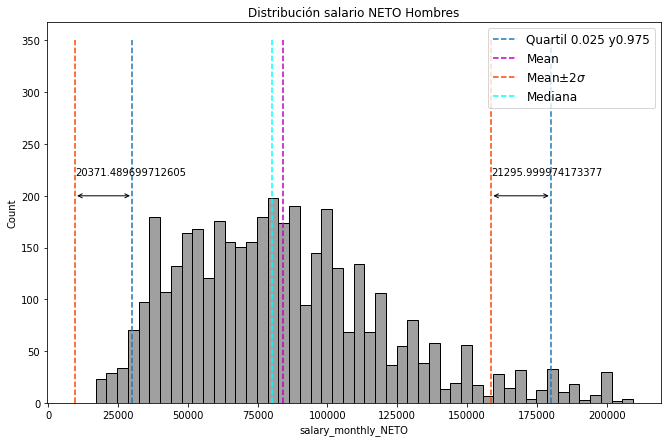

<ipython-input-22-c26f92257561>:26: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=str(q_025_B-(meanB-2*stdB)), xy=(meanB-2*stdB, 35), fontsize=10)
<ipython-input-22-c26f92257561>:27: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(meanB-2*stdB, 30), xytext=(q_025_B, 30), arrowprops=dict(arrowstyle='<->'))
<ipython-input-22-c26f92257561>:28: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=str(q_975_B-(meanB+2*stdB)), xy=(meanB+2*stdB, 35), fontsize=10)
<ipython-input-22-c26f92257561>:29: MatplotlibDeprecationWarning: The 's' parameter of annotate() has 

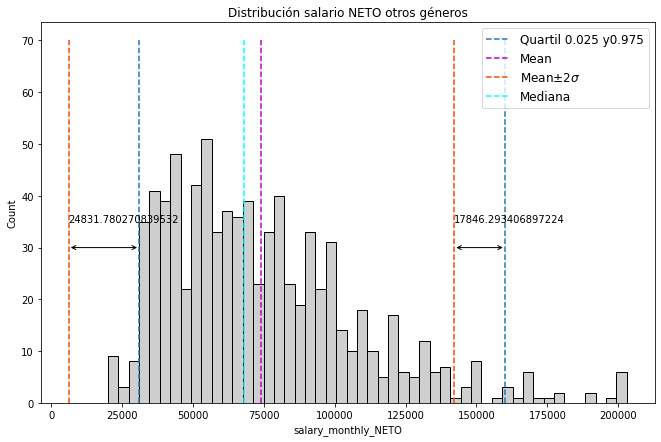

In [22]:
plt.figure(figsize=(11,7))
sns.histplot(groupA, bins=50, color='gray')
plt.vlines(q_025_A, 0, 350, linestyles='dashed', label='Quartil 0.025 y0.975')
plt.vlines(q_975_A, 0, 350, linestyles='dashed')
plt.vlines(meanA, 0, 350, linestyles='dashed', color='m', label='Mean')
plt.vlines(meanA-2*stdA, 0, 350, linestyles='dashed', color = 'orangered', label='Mean$\pm 2\sigma$ ')
plt.vlines(meanA+2*stdA, 0, 350, linestyles='dashed', color = 'orangered')
plt.vlines(medianA, 0, 350, color='cyan', linestyles='dashed', label='Mediana')
plt.annotate(s=str(q_025_A-(meanA-2*stdA)), xy=(meanA-2*stdA, 220), fontsize=10)
plt.annotate(s='', xy=(meanA-2*stdA, 200), xytext=(q_025_A, 200), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s=str(q_975_A-(meanA+2*stdA)), xy=(meanA+2*stdA, 220), fontsize=10)
plt.annotate(s='', xy=(meanA+2*stdA, 200), xytext=(q_975_A, 200), arrowprops=dict(arrowstyle='<->'))
plt.legend(fontsize = 12)
plt.title('Distribución salario NETO Hombres')
plt.show()


plt.figure(figsize=(11,7))
sns.histplot(groupB, bins=50, color='silver')
plt.vlines(q_025_B, 0, 70, linestyles='dashed', label='Quartil 0.025 y0.975')
plt.vlines(q_975_B, 0, 70, linestyles='dashed')
plt.vlines(meanB, 0, 70, linestyles='dashed', color='m', label='Mean')
plt.vlines(meanB-2*stdB, 0, 70, linestyles='dashed', color = 'orangered', label='Mean$\pm 2\sigma$ ')
plt.vlines(meanB+2*stdB, 0, 70, linestyles='dashed', color = 'orangered')
plt.vlines(medianB, 0, 70, color='cyan', linestyles='dashed', label='Mediana')
plt.annotate(s=str(q_025_B-(meanB-2*stdB)), xy=(meanB-2*stdB, 35), fontsize=10)
plt.annotate(s='', xy=(meanB-2*stdB, 30), xytext=(q_025_B, 30), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s=str(q_975_B-(meanB+2*stdB)), xy=(meanB+2*stdB, 35), fontsize=10)
plt.annotate(s='', xy=(meanB+2*stdB, 30), xytext=(q_975_B, 30), arrowprops=dict(arrowstyle='<->'))
plt.legend(fontsize = 12)
plt.title('Distribución salario NETO otros géneros')
plt.show()

A partir de los histogramas, las distribuciones dan toda la apariencia de que no son distribuciones normales

Una estimación puntual para la resta de la media para el salario neto de hombres y de otros generos es simplemente hacer la resta entre las medias de ambos grupos.

In [23]:
resta_means = meanA - meanB
print("media A - media B =", resta_means)
resta_varianza = stdA**2/na + stdB**2/nb
print("varianza A - varianza B=", resta_varianza)

media A - media B = 10005.292001925394
varianza A - varianza B= 1767363.441615075


## Calcular un intervalo de confianza de nivel $1-\alpha$ para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB).  ¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

Calcularemos ahora el intervalo de confianza con el nivel de significancia $\alpha = 0.05$, usamos la librería SciPy de python.

**scipy.stats.norm()** genera una muestra aleatoria con distribución normal continua.

**loc** es la media; con valor por default 0.

**scale** es la desviación estándar; con valor por default 1.

**interval(alpha, loc, scale)** nos da los extremos del intervalo que contiene el alpha$\%$ de la distribución.

**norm.pdf(x, loc, scale)** equivale a **norm.pdf(y) / scale** donde **y = (x - loc) / scale** 

In [24]:
sts.norm.interval(1-alpha, loc = resta_means, scale = math.sqrt(resta_varianza))

(7399.672328572325, 12610.911675278465)

Esto nos dice que si uno hace la diferencia entre las medias salariales de las dos poblaciones, hay un 95$\%$ de probabilidad de que esa diferencia esté entre $\$$7399 y $\$$12610.91

## Ejercicio 2: Test de hipótesis

### 2.1 Formalización

**Describir formalmente los distintos compenentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.**

**Hipótesis Nula a considerar**

$H_0=$ "La diferencia entre las medias de los grupos A y B es 0."

Como se vio anteriormente, las desviaciones estándar de las poblaciones son:

In [25]:
print('Desviacion estandar grupo A \t'+str(stdA))
print('Desviacion estandar grupo B \t'+str(stdB))

Desviacion estandar grupo A 	37268.87243138481
Desviacion estandar grupo B 	33996.37171598557


Por lo que asumimos que las poblaciones tienen desviaciones estándar distintas. Tienen además tamaños distintos(la población A es aproximadamente 5 veces más numerosa que la población B). Queremos hacer un test de igualdad de medias para muestras que tienen distinta varianza. Para realizarlo, tenemos que emplear un **test de Welch**. El mismo usa el estadístico t de student con k grados de libertad. 

Buscamos implementar el Welch-t-test en python; de la documentación:

**scipy.stats.ttest_ind(poblacion1, poblacion2, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')**

Calcula el T-test para dos poblaciones, bajo la hipótesis nula de que las medias de las poblaciones son iguales. 
Se asume que las varianzas de las poblaciones son iguales (se asume **equal$\_$var=True**)
Para que se aplique el verdadero test de Welch, es necesario el input **equal$\_$var=False**

El campo **alternative{‘two-sided’, ‘less’, ‘greater’}** es opcional y define la hipótesis alternativa. Tiene las opciones ‘two-sided’, ‘less’: one-sided, ‘greater’: one-sided.

**Estadístico (Pivote)**
  **El estadístico que nos devuelve este test es : **
  
t = (meanA - meanB)/ sqrt (Q)

donde

Q = (stdA / n$\_$A) + (stdB / n$\_$B)


meanA = groupA.mean() es la media muestral de la población A

meanB = groupB.mean() es la media muestral de la población B

stdA = groupA.std() es la desviación estándar muestral de la población A

stdB = groupB.std() es la desviación estándar muestral de la población B

n$\_$A = groupB.count() es el tamaño de la población A

n$\_$B = groupA.count() es el tamaño de la población B

In [27]:
sts.ttest_ind(groupA, groupB, equal_var=False, alternative="two-sided")

Ttest_indResult(statistic=7.526045408363483, pvalue=1.0016582714320966e-13)

### 2.2 P-valor
1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Como el p-valor es muy pequeño, en particular menor a nuestro nivel de significancia $\alpha=0.05$, podemos concluir que nuestros datos son estadísticamente significantes y que la hipótesis nula puede ser rechazada. Esto nos dice que las medias de las poblaciones NO son iguales.

**Escribir qué distribución tiene bajo $H_0$**

Para ello generamos muestras aleatorias que simulan los grupos A y B. Las muestras seguirán una distribución normal,
con las mismas media, desviación y tamaño de A y B , respectivamente. Se les aplicará el **Welch-t-test** a esas muestras, 
y se almacenarán los estadísticos t en un dataframe.

In [29]:
from numpy.random import seed
from numpy.random import normal

#make this example reproducible
estadisticos_t=[]

for i in range(1000):
    seed(i)

    dataA = normal(loc=meanA, scale=stdA, size=groupA.count())
    dataB = normal(loc=meanB, scale=stdB, size=groupB.count())
    
    estadisticos_t.append(sts.ttest_ind(dataA, dataB, equal_var=False)[0])

estadisticos_t=pd.DataFrame(estadisticos_t)

Calculamos la media y desviación de la muestra, y realizamos un histograma, con el **kde** incluido.

In [30]:
a=estadisticos_t.mean()[0]
b=estadisticos_t.std()[0]
print("La distribución de estadísticos-t tiene respectivamente media y desviación: ("+str(a)+" , "+str(b)+")")

La distribución de estadísticos-t tiene respectivamente media y desviación: (7.516451815075345 , 0.9807765758400852)


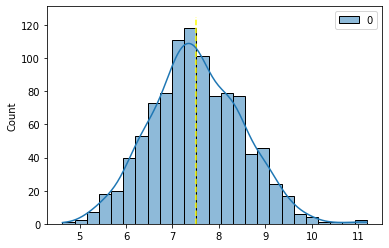

In [31]:
sns.histplot(estadisticos_t, kde=True)
plt.vlines(estadisticos_t.mean()[0], 0, 125, linestyles='dashed', color='yellow', label='Mean')

Se ve entonces que el estadístico sigue una distribución normal, con media 7.51 y desviación 0.98 .

**3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?**

La población del Grupo B (el de menor tamaño), es de más de 800 personas; lo suficientemente grande como para que las conclusiones estadísticas al respecto sean válidas.

Además, los links sobre tests de Student y Welch nos explican que para poblaciones de suficiente tamaño, los tests son válidos de aplicar.

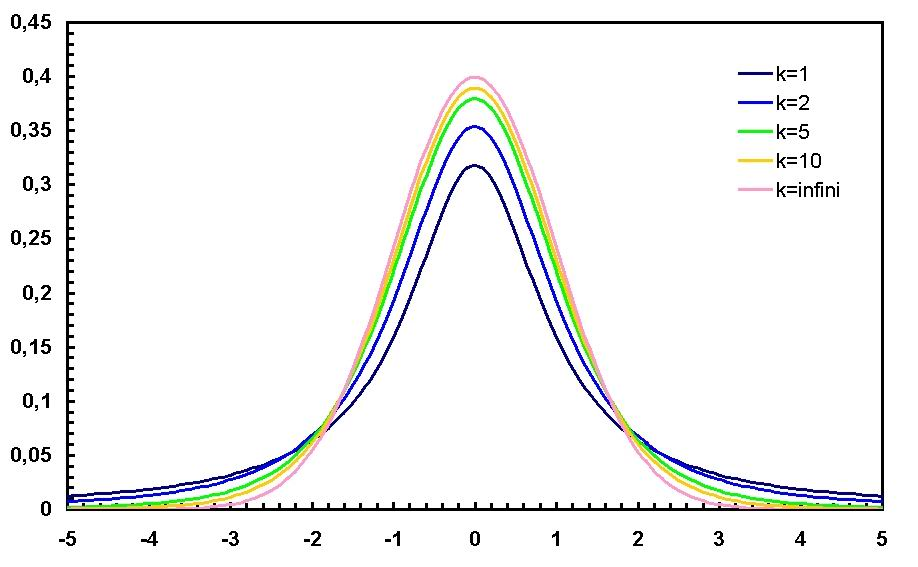

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)

In [ ]:
tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
